[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/logistic-regression-torch.ipynb)


In [2]:
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [3]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.linear(x)
        return logits

In [4]:
from sklearn.datasets import make_moons

In [6]:
X, y = make_moons(n_samples=100, noise=0.1)

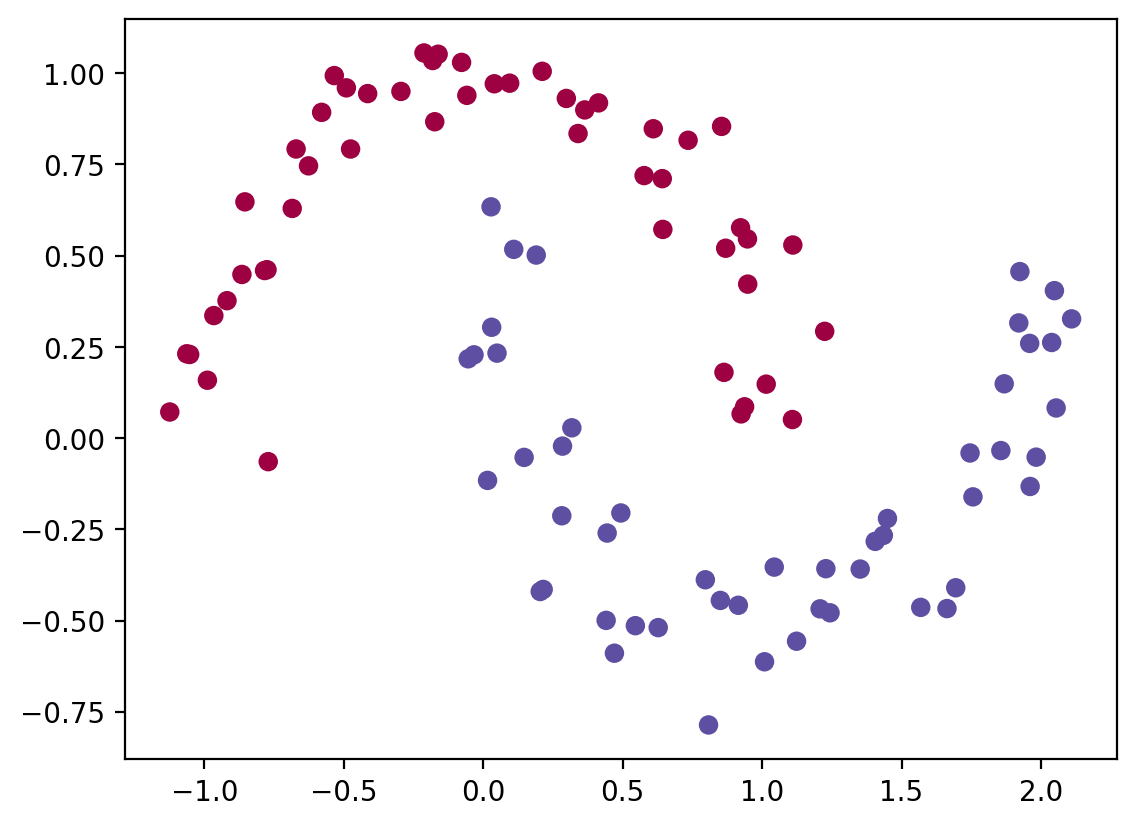

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [8]:
log_reg = LogisticRegression(2)

In [9]:
log_reg.linear.weight, log_reg.linear.bias

(Parameter containing:
 tensor([[0.6758, 0.4935]], requires_grad=True),
 Parameter containing:
 tensor([-0.3427], requires_grad=True))

In [10]:
log_reg(torch.tensor([1, 0.0]))

tensor([0.3330], grad_fn=<ViewBackward0>)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


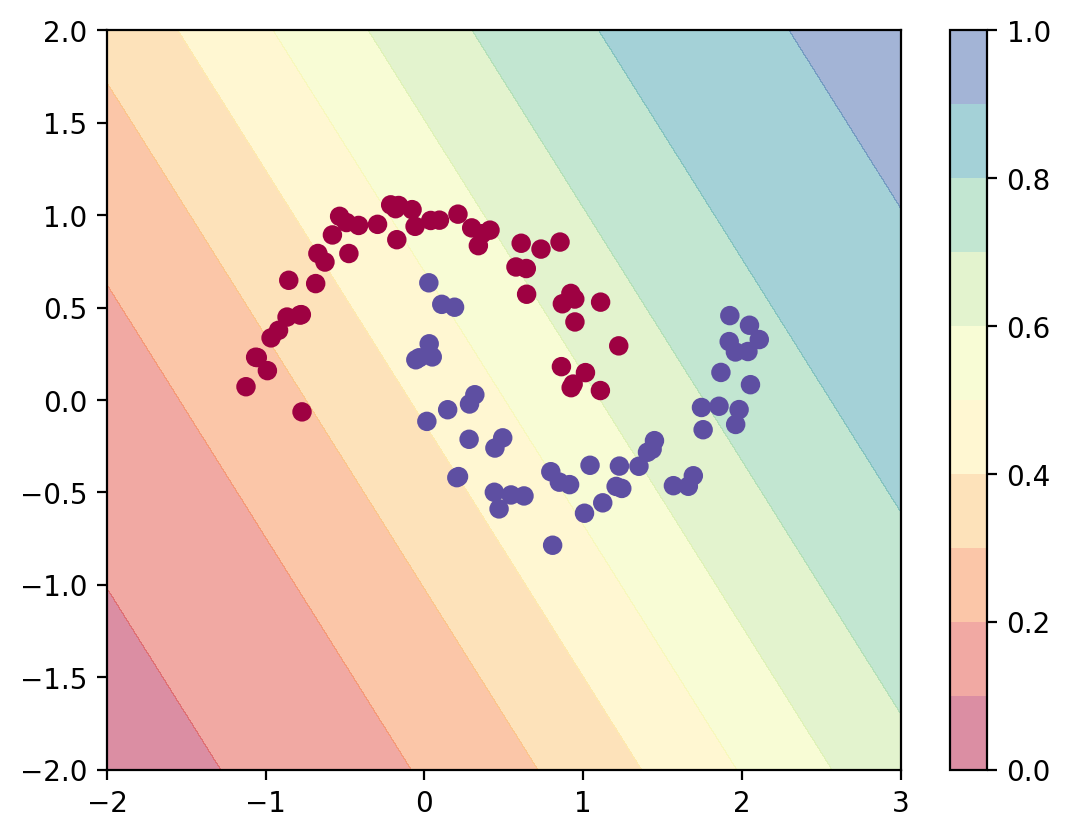

In [11]:
# Predict with the model

def predict_plot_grid(model):
    XX, YY = torch.meshgrid(torch.linspace(-2, 3, 100), torch.linspace(-2, 2, 100))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    probs = torch.sigmoid(logits).reshape(100, 100)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0],
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

predict_plot_grid(log_reg)



In [12]:


opt = torch.optim.Adam(log_reg.parameters(), lr=0.01)

converged = False
prev_loss = 1e8
i = 0
while not converged:
    opt.zero_grad()
    logits = log_reg(torch.tensor(X, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, torch.tensor(y, dtype=torch.float32).view(-1, 1))
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item()
    i = i + 1


0 0.6560194492340088
10 0.6222368478775024
20 0.5931639671325684
30 0.5680631995201111
40 0.546377956867218
50 0.5277280807495117
60 0.5115939974784851
70 0.4975294768810272
80 0.48514601588249207
90 0.4741223454475403
100 0.46420058608055115
110 0.4551752507686615
120 0.4468850791454315
130 0.4392036199569702
140 0.43203285336494446
150 0.4252965450286865
160 0.41893595457077026
170 0.4129054546356201
180 0.407169908285141
190 0.401701956987381
200 0.39648038148880005
210 0.3914879858493805
220 0.3867112696170807
230 0.38213881850242615
240 0.37776118516921997
250 0.3735697865486145
260 0.36955711245536804
270 0.3657160997390747
280 0.36204010248184204
290 0.3585226833820343
300 0.3551577031612396
310 0.35193902254104614
320 0.34886065125465393
330 0.3459169268608093
340 0.3431020677089691
350 0.34041059017181396
360 0.3378370702266693
370 0.3353762924671173
380 0.33302322030067444
390 0.3307729959487915
400 0.32862091064453125
410 0.3265624940395355
420 0.32459351420402527
430 0.3227

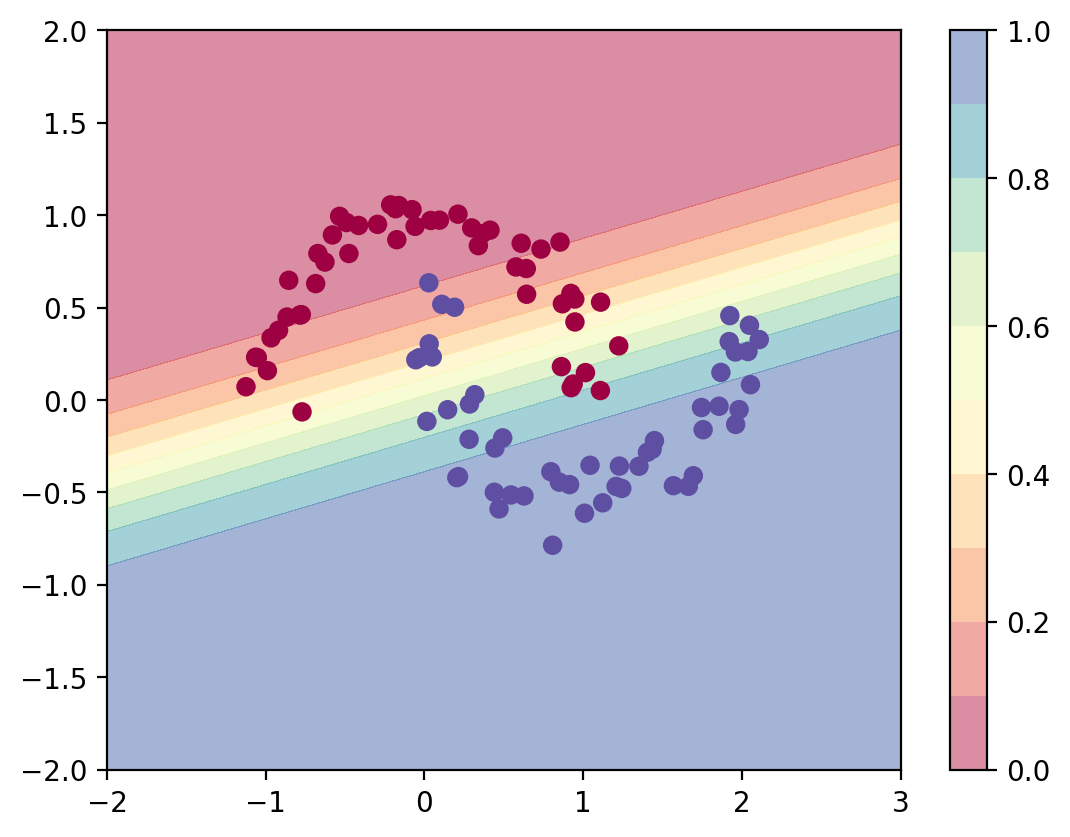

In [13]:
predict_plot_grid(log_reg)

## Second-Order Logistic Regression (Newton's Method)

Now we'll implement logistic regression using Newton's method, which uses the Hessian matrix for faster convergence.

In [14]:
# Implement Newton's Method for Logistic Regression
class LogisticRegressionNewton:
    def __init__(self, input_dim):
        self.theta = np.zeros((input_dim + 1, 1))  # +1 for bias

    def add_intercept(self, X):
        """Add intercept term to features"""
        return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

    def sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-z))

    def predict_proba(self, X):
        """Predict probabilities"""
        X_with_intercept = self.add_intercept(X)
        return self.sigmoid(X_with_intercept @ self.theta)

    def compute_gradient_hessian(self, X, y):
        """Compute gradient and Hessian for Newton's method"""
        X_with_intercept = self.add_intercept(X)
        n = X.shape[0]

        # Predictions
        pi = self.sigmoid(X_with_intercept @ self.theta)

        # Gradient: X^T(pi - y)
        gradient = X_with_intercept.T @ (pi - y.reshape(-1, 1))

        # Hessian: X^T S X where S = diag(pi_i(1-pi_i))
        S = pi * (1 - pi)
        Hessian = X_with_intercept.T @ (S * X_with_intercept)

        return gradient, Hessian

    def fit(self, X, y, max_iter=100, tol=1e-5):
        """Fit using Newton's method"""
        losses = []

        for i in range(max_iter):
            # Compute gradient and Hessian
            gradient, Hessian = self.compute_gradient_hessian(X, y)

            # Compute loss
            pi = self.predict_proba(X)
            loss = -np.mean(y.reshape(-1, 1) * np.log(pi + 1e-10) +
                           (1 - y.reshape(-1, 1)) * np.log(1 - pi + 1e-10))
            losses.append(loss)

            if i % 10 == 0:
                print(f"{i} Loss: {loss:.6f}")

            # Newton's update: theta = theta - H^{-1} * gradient
            try:
                delta = np.linalg.solve(Hessian, gradient)
                self.theta = self.theta - delta
            except np.linalg.LinAlgError:
                print("Hessian is singular, stopping early")
                break

            # Check convergence
            if i > 0 and np.abs(losses[-1] - losses[-2]) < tol:
                print(f"Converged at iteration {i}")
                break

        return losses

In [15]:
# Train using Newton's method
log_reg_newton = LogisticRegressionNewton(input_dim=2)
losses_newton = log_reg_newton.fit(X, y, max_iter=100)

0 Loss: 0.693147
Converged at iteration 5


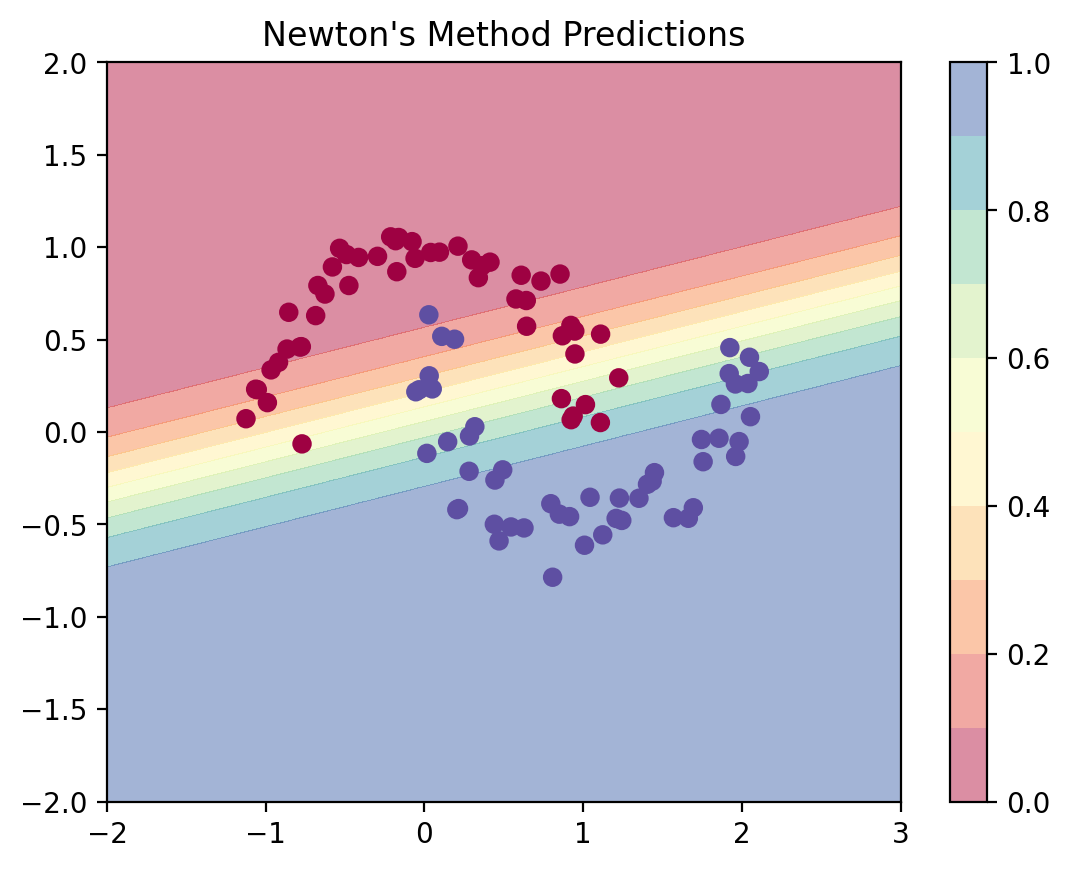

In [16]:
# Visualize predictions from Newton's method
def predict_plot_grid_newton(model, X_data, y_data):
    XX, YY = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-2, 2, 100))
    X_grid = np.c_[XX.ravel(), YY.ravel()]
    probs = model.predict_proba(X_grid).reshape(100, 100)

    plt.contourf(XX, YY, probs, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()
    plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.Spectral)
    plt.title("Newton's Method Predictions")

predict_plot_grid_newton(log_reg_newton, X, y)

## Comparing Convergence: Gradient Descent vs Newton's Method

Let's compare how fast each method converges by tracking their losses over iterations.

In [17]:
# Extract losses from gradient descent (Adam optimizer)
# We need to re-run with loss tracking
log_reg_gd = LogisticRegression(2)
opt = torch.optim.Adam(log_reg_gd.parameters(), lr=0.01)

losses_gd = []
max_iter = 100
for i in range(max_iter):
    opt.zero_grad()
    logits = log_reg_gd(torch.tensor(X, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, torch.tensor(y, dtype=torch.float32).view(-1, 1))
    loss.backward()
    opt.step()
    losses_gd.append(loss.item())
    if i % 10 == 0:
        print(f"{i} Loss: {loss.item():.6f}")

0 Loss: 0.554762
10 Loss: 0.518786
20 Loss: 0.487973
30 Loss: 0.462311
40 Loss: 0.441334
50 Loss: 0.424334
60 Loss: 0.410566
70 Loss: 0.399353
80 Loss: 0.390129
90 Loss: 0.382437


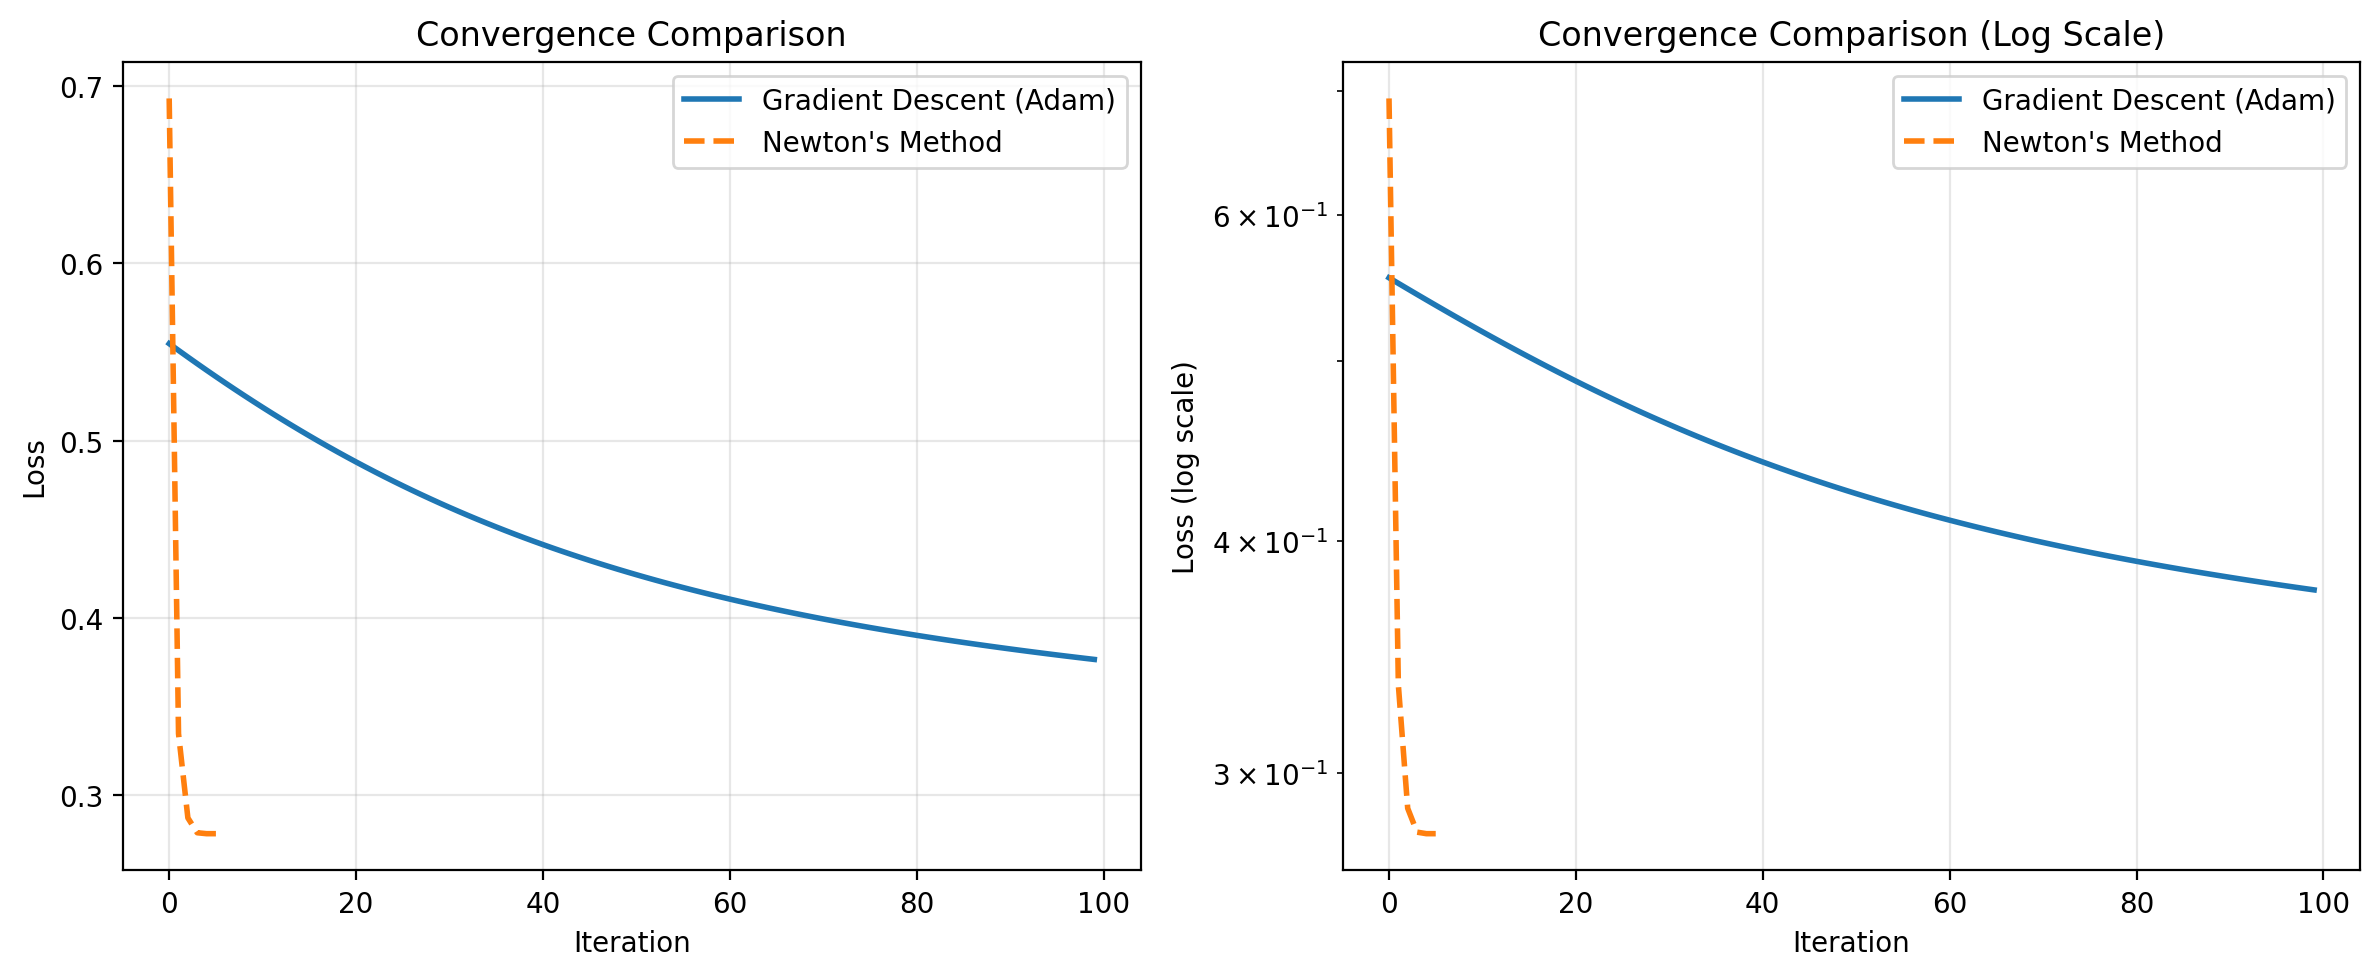

In [18]:
# Plot convergence comparison
plt.figure(figsize=(12, 5))

# Plot 1: Loss over iterations
plt.subplot(1, 2, 1)
plt.plot(losses_gd, label='Gradient Descent (Adam)', linewidth=2)
plt.plot(losses_newton, label="Newton's Method", linewidth=2, linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Convergence Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Log scale to see convergence better
plt.subplot(1, 2, 2)
plt.semilogy(losses_gd, label='Gradient Descent (Adam)', linewidth=2)
plt.semilogy(losses_newton, label="Newton's Method", linewidth=2, linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Convergence Comparison (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Print convergence statistics
print("=" * 60)
print("CONVERGENCE COMPARISON")
print("=" * 60)
print(f"Gradient Descent (Adam):")
print(f"  - Iterations to converge: {len(losses_gd)}")
print(f"  - Final loss: {losses_gd[-1]:.6f}")
print()
print(f"Newton's Method:")
print(f"  - Iterations to converge: {len(losses_newton)}")
print(f"  - Final loss: {losses_newton[-1]:.6f}")
print()
print(f"Speedup: {len(losses_gd) / len(losses_newton):.2f}x faster convergence!")
print("=" * 60)

CONVERGENCE COMPARISON
Gradient Descent (Adam):
  - Iterations to converge: 100
  - Final loss: 0.376527

Newton's Method:
  - Iterations to converge: 6
  - Final loss: 0.278184

Speedup: 16.67x faster convergence!


## Key Observations

1. **Newton's Method converges much faster** - typically in 5-10 iterations vs 100+ for gradient descent
2. **Quadratic vs Linear Convergence** - Newton's method has quadratic convergence near the optimum, while gradient descent has linear convergence
3. **Cost per iteration** - Newton's method is more expensive per iteration (requires computing and inverting the Hessian), but the total number of iterations is dramatically smaller
4. **When to use Newton's Method:**
   - Small to medium number of features (d < 1000)
   - High accuracy is needed
   - Batch setting (all data available)
   - Well-conditioned problems